<a href="https://colab.research.google.com/github/bskrish757/AIML/blob/main/Capstone_RSNA_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: 
Pneumonia is a deadly disease which accounts to top 10 causes of deaths world wide especially childrens.
Diagnosis of this disease is done through the review of Chest Radiograph images,
pneumonia appears to be areas of high opacity in these images, as the areas affected in lungs will be filled with mucus/pus and doesnot allow xrays to pass through.

The challenge in diagnosing pneumonia through CXR images are
* Only the highly trained specialist doctors have to review the Chest Radiograph images, patients clinical history and has to take a lot of laboratory examinations for confirmation.
* The conditions such as fluid overload also appears to be the areas with high opacity in these images.
* The specialist have to review lot of images per shift making room for human errors aswell.

So to solve these problems a dataset of CXRs is provided by medical associations accross the globe,
Through Machine learning we have to develop a model which will help to automate the initial detection of potential pneumonia cases.


### Data Descrption: 

### Expected output:


# Download Kaggle

Steps to download:
1. Create an acccout in https://www.kaggle.com/ with the account you signed in to google colab,drive
2. Go to account settings --> API -->Create New API Token
3. A kaggle.json file will be downloaded, copy it to the google drive location
4. and use it in the below steps wherever specified

In [1]:
!pip install kaggle

In [2]:
#Make a directory for Kaggle
!mkdir .kaggle

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
#Copy kaggle.json file which 
!cp '/gdrive/My Drive/Colab Notebooks/kaggle.json' /content/.kaggle/kaggle.json

In [5]:
#Check if json file is there
!ls -l /content/.kaggle

total 4
-rw------- 1 root root 65 May 31 06:37 kaggle.json


In [6]:
!mkdir ~/.kaggle


In [7]:
!cp /content/.kaggle/kaggle.json  ~/.kaggle

In [8]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [9]:
!chmod 600 /root/.kaggle/kaggle.json

In [10]:
#To Avoid the error "Warning: Looks like you're using an outdated API Version, please consider updating (server 1.5.12 / client 1.5.4)" 
#and also to download dataset properly the below command is neccessary
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 1.7MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=6ece31a54fe06df57827568bf4e2a86283e85183b2e6832e4ce80c03d1c443d2
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


# Download RSNA competition dataset

In [11]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-05-29 17:43:56           6347        567  1.0              
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           3645        305  0.9375           
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1275        109  1.0              
dhruvildave/wikibooks-dataset                               Wikibooks Dataset             

In [12]:
#Download data from Kaggle for RSNA PNEUMONIA DETECTION and copy it to /content folder
!kaggle competitions download -c rsna-pneumonia-detection-challenge -p /content

100% 3.66G/3.66G [01:15<00:00, 72.8MB/s]
100% 3.66G/3.66G [01:15<00:00, 52.0MB/s]


In [13]:
!unzip rsna-pneumonia-detection-challenge.zip --quiet

Streaming output truncated to the last 5000 lines.
  inflating: stage_2_train_images/d5231546-354e-4071-9af1-6644beabfd86.dcm  
  inflating: stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  inflating: stage_2_trai

In [14]:
!ls -l

total 3845444
-rw-r--r-- 1 root root         55 Dec 11  2019 'GCP Credits Request Link - RSNA.txt'
-rw-r--r-- 1 root root 3932287530 May 31 06:39  rsna-pneumonia-detection-challenge.zip
drwxr-xr-x 1 root root       4096 May  6 13:44  sample_data
-rw-r--r-- 1 root root    1647396 Dec 11  2019  stage_2_detailed_class_info.csv
-rw-r--r-- 1 root root     159027 Dec 11  2019  stage_2_sample_submission.csv
drwxr-xr-x 2 root root     233472 May 31 06:41  stage_2_test_images
drwxr-xr-x 2 root root    1892352 May 31 06:42  stage_2_train_images
-rw-r--r-- 1 root root    1490034 Dec 11  2019  stage_2_train_labels.csv


In [15]:
!ls  stage_2_train_images/ | wc -l

26684


In [16]:
!ls  stage_2_test_images/ | wc -l

3000


# EDA using pandas

In [17]:
# Import the pandas and numpy packages for eda
import pandas as pd
import numpy as np

In [37]:
train_labels_df = pd.read_csv('stage_2_train_labels.csv')

In [38]:
train_labels_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [20]:
train_labels_df['Target'].unique()

array([0, 1])

In [21]:
train_labels_df.shape

(30227, 6)

In [22]:
train_labels_df.patientId.unique().shape

(26684,)

In [24]:
train_labels_df.dtypes

patientId     object
x            float64
y            float64
width        float64
height       float64
Target         int64
dtype: object

In [25]:
train_labels_df.isnull().sum() 
#Out of 30227 rows, 20672 do not have bounding boxes, which according to the data set description are normal

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
dtype: int64

In [39]:
# We cannot give NAN, zeroes or  values greater than image size for bounding boxes to the model as per my understanding the
# so we can do  one thing we can write out the code for imuting these values to image size or mean value
train_df_mean_imputed = train_labels_df.copy()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
train_df_mean_imputed.iloc[:,1:] = imputer.fit_transform(train_df_mean_imputed.iloc[:,1:])
train_df_mean_imputed.isnull().sum()

patientId    0
x            0
y            0
width        0
height       0
Target       0
dtype: int64

## Observations from training_labels csv file
1. There are 2 classes/targets -> 0-Normal , 1-Pneumonia
2. There are around 30227 examples in the training data
3. Out of the total examples 26684 are unique, which means remaining are duplicate of one or the other patient, where it means that there are more than 1 bounding boxes for some patients
4. Some Patients which are classified as NORMAL do not have bounding boxes in the training data
5. Observed that there are around 20,672 patients are normal and have NULL values for the bounding box co-ordinates x,y, width,height 

In [40]:
class_info_df = pd.read_csv('stage_2_detailed_class_info.csv')

In [41]:
class_info_df.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [42]:
class_info_df.shape
#the class info details are having same number of rows or patient details

(30227, 2)

In [43]:
class_info_df['class'].unique()

array(['No Lung Opacity / Not Normal', 'Normal', 'Lung Opacity'],
      dtype=object)

In [68]:
# If we want to keep the class name mapped in the training labels file, we can check if the patientId's are same as in the detailed class info, 
# if they are same Append the class names in the class data set 'stage_2_detailed_class_info.csv' to 'stage_2_train_labels.csv'
if (True == train_labels_df['patientId'].equals(other=class_info_df['patientId'])):
    train_labels_df['class'] = class_info_df['class'].copy()

In [69]:
#Check if the class names and target mappings as pet the training labels data
#patient Id = 0004cfab-14fd-4e49-80ba-63a80b6bddd6 is of class No Lung Opacity / Not Normal
train_labels_df[train_labels_df['patientId'] == '0004cfab-14fd-4e49-80ba-63a80b6bddd6']

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


In [45]:
#Check if the class names and target mappings as pet the training labels data
#patient Id = 003d8fa0-6bf1-40ed-b54c-ac657f8495c5 is of class 'Normal'
train_labels_df[train_labels_df['patientId'] == '003d8fa0-6bf1-40ed-b54c-ac657f8495c5']

,patientId,x,y,width,height,Target
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0


In [46]:
#Check if the class names and target mappings as pet the training labels data
#patient Id = 00436515-870c-4b36-a041-de91049b9ab4 is of class 'Lung Opacity'
train_labels_df[train_labels_df['patientId'] == '00436515-870c-4b36-a041-de91049b9ab4']

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [47]:
train_labels_df[train_labels_df['x'].max() == train_labels_df.x]

,patientId,x,y,width,height,Target
29048,02475a31-ed48-4ff3-b401-5d74694bff8d,835.0,474.0,112.0,172.0,1


In [48]:
train_labels_df[train_labels_df['x'].min() == train_labels_df.x]

,patientId,x,y,width,height,Target
3167,36994bd6-13dc-405e-9f98-680a0e5b2eea,2.0,483.0,273.0,435.0,1
13510,87bea6bd-4a01-4fad-8621-8e641e09dcad,2.0,383.0,326.0,289.0,1
14492,8f202a05-d9d3-43c2-aa4b-0ab8939f0607,2.0,236.0,348.0,551.0,1


In [49]:
train_labels_df.describe()

,x,y,width,height,Target
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108
std,204.574172,148.940488,59.289475,157.750755,0.464963
min,2.000000,2.000000,40.000000,45.000000,0.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


In [74]:
train_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.6+ MB


In [51]:
# BOx plot for x, y, width, height
import seaborn as sns
import matplotlib.pyplot as plt

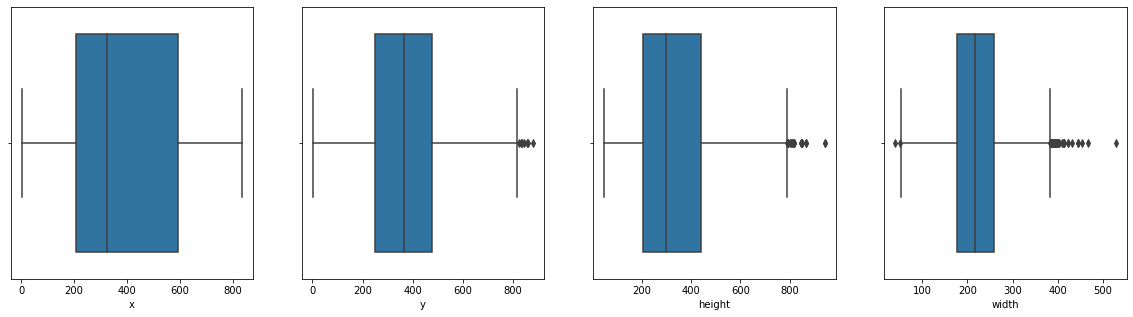

In [52]:
fig, ax = plt.subplots(1,4)
fig.set_size_inches(20, 5)
sns.boxplot(x='x', data=train_labels_df, ax=ax[0])
sns.boxplot(x='y', data=train_labels_df, ax=ax[1])
sns.boxplot(x='height', data=train_labels_df, ax=ax[2])
sns.boxplot(x='width', data=train_labels_df, ax=ax[3])

# Here we can see that the height, width and y coordinate has some outliers, which means the bounding boxes in some cxr images of patients are bigger
# We have to decide whether we need to really change them and bring back to mean position or any other quartile value
# If we do that then our bounding boxes which capture the opacity may go wrong, so we can observe some example bounding boxes on the training images which are treated as outliers 

In [53]:
#Display the patientId which have outliers in there data
#store them in a different data frames
h1 =  train_labels_df['height'].quantile(0.25)
h3 = train_labels_df['height'].quantile(0.75)
IQR_H = h3 - h1
print(f"The highest whisker value of Height is : {h3 + IQR_H*1.5}")

w1 =  train_labels_df['width'].quantile(0.25)
w3 = train_labels_df['width'].quantile(0.75)
IQR_W = w3 - w1
print(f"The highest whisker value of weight is : {w3 + IQR_W*1.5}")

y1 =  train_labels_df['y'].quantile(0.25)
y3 = train_labels_df['y'].quantile(0.75)
IQR_Y = y3 - y1
print(f"The highest whisker value of y is : {y3 + IQR_Y*1.5}")

The highest whisker value of Height is : 790.5
The highest whisker value of weight is : 382.0
The highest whisker value of y is : 822.75


In [54]:
print("The number of patients having bounding box heights treated as outliers = ", train_labels_df[train_labels_df['height'] > h3+1.5*IQR_H].shape[0])
print("The number of patients having bounding box width treated as outliers = ", train_labels_df[train_labels_df['width'] > w3+1.5*IQR_W].shape[0])
print("The number of patients having bounding box y co-ordinate treated as outliers = ", train_labels_df[train_labels_df['height'] > y3+1.5*IQR_Y].shape[0])

The number of patients having bounding box heights treated as outliers =  18
The number of patients having bounding box width treated as outliers =  36
The number of patients having bounding box y co-ordinate treated as outliers =  8


In [55]:
# we cannot change the width height or y coordinate directly, so we will observe the output of some of these
# and check if the bounding boxes are not properly defined and remove if required

In [56]:
train_height_outliers = train_labels_df[train_labels_df['height'] > h3+1.5*IQR_H]
train_height_outliers

,patientId,x,y,width,height,Target
241,0637b804-e693-48d1-8716-f7c63ce6162a,507.0,109.0,344.0,808.0,1
3808,3accdbb1-0300-4065-8757-94eb3dd213c3,123.0,204.0,332.0,816.0,1
3809,3accdbb1-0300-4065-8757-94eb3dd213c3,621.0,172.0,339.0,852.0,1
4097,3ca6661a-ffbd-4d4d-b49b-c96cfd218307,87.0,104.0,310.0,793.0,1
4098,3ca6661a-ffbd-4d4d-b49b-c96cfd218307,549.0,82.0,280.0,942.0,1
4357,3e62e51c-befb-4a66-b28e-fc469b19e4a8,148.0,87.0,366.0,867.0,1
4358,3e62e51c-befb-4a66-b28e-fc469b19e4a8,620.0,82.0,335.0,942.0,1
13699,893b6861-0bfc-4e9f-94d4-3a967dda4223,156.0,28.0,320.0,816.0,1
14917,92a2dfab-f33a-4324-953a-afe96680c541,102.0,196.0,325.0,805.0,1
14918,92a2dfab-f33a-4324-953a-afe96680c541,520.0,201.0,374.0,817.0,1


In [57]:
train_width_outliers = train_labels_df[train_labels_df['width'] > w3+1.5*IQR_W]
train_width_outliers

,patientId,x,y,width,height,Target
400,074f8729-c5ea-4830-8249-9a04208eab5e,13.0,526.0,422.0,296.0,1
401,074f8729-c5ea-4830-8249-9a04208eab5e,611.0,515.0,393.0,327.0,1
430,077ff78d-27ef-49d4-9e8e-00e458844a3e,550.0,129.0,386.0,745.0,1
591,08da8f40-b186-473b-9fa3-1caa4ecdc02b,496.0,130.0,394.0,755.0,1
642,0930b0aa-25c2-4624-a3fc-9b60ba0b23f4,471.0,8.0,445.0,568.0,1
678,097788d4-cb88-4457-8e71-0ca7a3da2216,226.0,189.0,528.0,703.0,1
754,0a03fbf6-3c9a-4e2e-89ce-c7629ae43a27,582.0,522.0,403.0,444.0,1
817,0aa43663-a1f3-44cb-8ecc-9b36fbb0d778,486.0,129.0,397.0,649.0,1
1043,0c391e0f-9927-48ce-801f-02eb000f72c3,486.0,230.0,467.0,738.0,1
1108,0cc09b0a-1afc-4492-929e-ac53f15286b6,538.0,282.0,388.0,491.0,1


In [58]:
train_y_outliers = train_labels_df[train_labels_df['y'] > y3+1.5*IQR_Y]
train_y_outliers

,patientId,x,y,width,height,Target
52,01be392f-a46d-4aef-a57e-9cd1a80dd47e,175.0,825.0,168.0,109.0,1
2495,32408669-c137-4e8d-bd62-fe8345b40e73,273.0,856.0,234.0,101.0,1
3185,36c50ee5-7885-4c34-8f24-829f85cea256,583.0,836.0,148.0,177.0,1
4504,3f4eae54-fb2b-4616-a32f-c42f7df570b7,135.0,832.0,155.0,134.0,1
10900,729f2aa0-9564-4228-b516-1d8d4be8bb55,574.0,845.0,165.0,110.0,1
10920,72dc0bc2-8c6a-4214-b06f-862e9e8444bd,586.0,859.0,174.0,105.0,1
25982,e821a416-aed0-411d-ab8a-7813185384b9,39.0,881.0,108.0,128.0,1


In [59]:
#Example of duplicates in patient ID and there respective bounding boxes
train_labels_df[train_labels_df['patientId'] == '32408669-c137-4e8d-bd62-fe8345b40e73']

,patientId,x,y,width,height,Target
2495,32408669-c137-4e8d-bd62-fe8345b40e73,273.0,856.0,234.0,101.0,1
2496,32408669-c137-4e8d-bd62-fe8345b40e73,702.0,801.0,249.0,144.0,1
2497,32408669-c137-4e8d-bd62-fe8345b40e73,300.0,367.0,226.0,423.0,1
2498,32408669-c137-4e8d-bd62-fe8345b40e73,706.0,360.0,232.0,238.0,1


# VISUALIZATION

In [60]:
import matplotlib.pyplot as plt
import cv2

!pip install pydicom

     |████████████████████████████████| 1.9MB 2.9MB/s 


In [61]:
import pydicom as dicom
import matplotlib.patches as patches
import math

In [63]:
img_path = 'stage_2_train_images'

In [64]:
def display_image_and_bounding_boxes(df, img_num_list, img_path, fig_height=20, fig_width=10):    
    num_rows = math.ceil(len(img_num_list)/4)
    num_cols = 4    
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(fig_height,fig_width))
    row = 0
    col = 0
    for img_num in img_num_list:
        #Read the image
        img_file = df.loc[img_num, 'patientId']
        #Find all images with this patient id
        rows_with_patientid = df[(df.patientId == img_file)].index.tolist()
        for i in rows_with_patientid:              
            #Get bounding box
            xmin, ymin, width, height = df.loc[i, ['x', 'y', 'width', 'height']]
            xmax = xmin+width
            ymax = ymin+height
            #img = cv2.imread(img_path + '/' + img_file+'.dcm')
            
            ds = dicom.dcmread(img_path + '/' + img_file+'.dcm')

            #print using cv requires xmax, ymax instead of height ad width and in int format
            #opecv needs values in int format, our values are in float
            #xmin = xmin.astype('int')
            #ymax= ymax.astype('int')
            #xmax = xmax.astype('int')
            #ymin= ymin.astype('int')      
            #cv2.rectangle(ds.pixel_array, (xmin,ymin), (xmax, ymax), (0,255,0), 2)
            #Get Label and Add text 
            #cv2.putText(ds.pixel_array,label,(xmin, ymin),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

            rect = patches.Rectangle((xmin,ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax[row, col].add_patch(rect)            
            ax[row, col].set_title(ds.PatientID)
            
        #ds.pixel_array = cv2.cvtColor(ds.pixel_array, cv2.COLOR_BGR2RGB)
        #ax[row, col].grid(None)
        ax[row, col].imshow(ds.pixel_array, cmap=plt.cm.gray)
        col = col+1
        if (col == num_cols):
            row = row+1
            col = 0            

    plt.show()
        

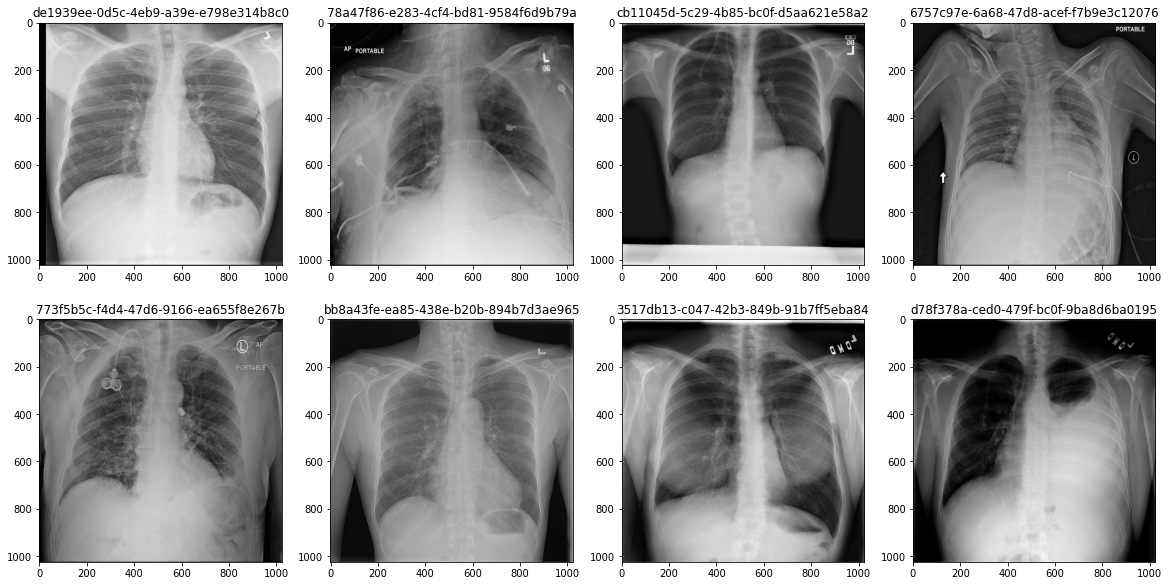

In [70]:
#Diplay the negative cases without bounding boxes, print random values
train_negative = train_labels_df[train_labels_df['Target'] == 0].copy().reset_index(drop=True)

#Get some 6 random numbers and display those images
img_num = [np.random.randint(0, train_negative.shape[0]) for i in range(8)]
display_image_and_bounding_boxes(train_negative, img_num, img_path)

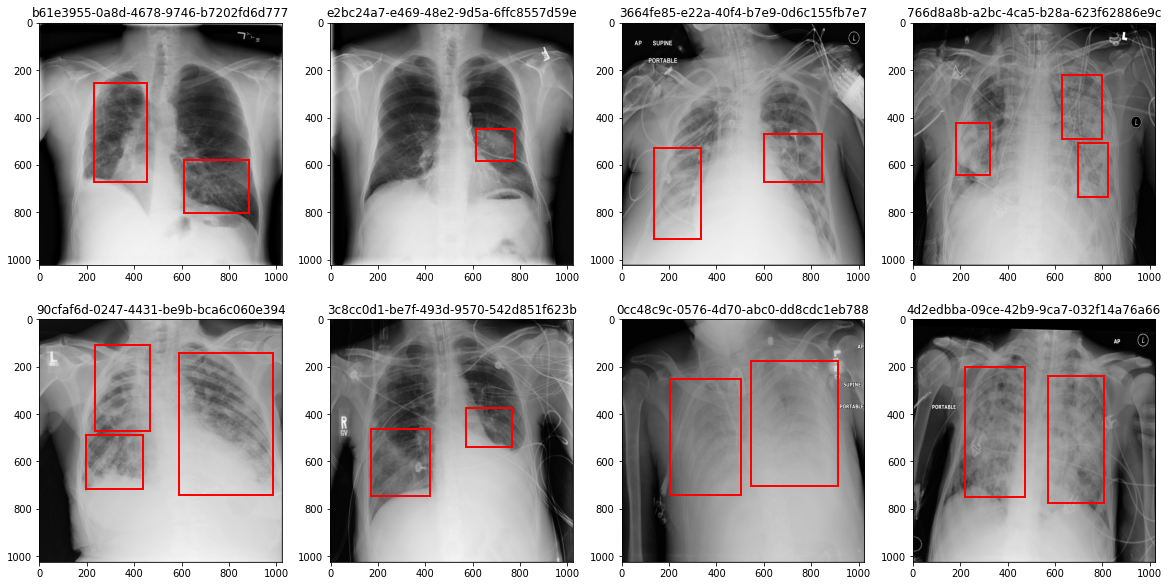

In [71]:
#Diplay the positive cases with bounding boxes
train_positive = train_labels_df[train_labels_df['Target'] == 1].copy().reset_index(drop=True)

#Get some 6 random numbers and display those images
img_num = [np.random.randint(0, train_positive.shape[0]) for i in range(8)]
display_image_and_bounding_boxes(train_positive, img_num, img_path)

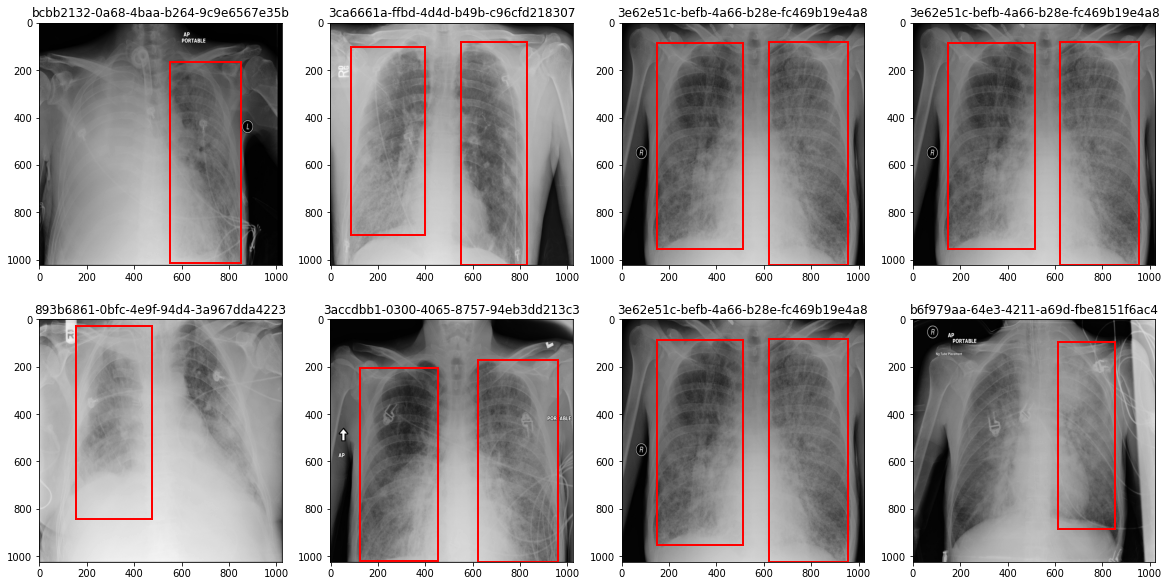

In [72]:
#Diplay the outlier image cases with bounding boxes
df = train_height_outliers.copy().reset_index(drop=True)

#Get more than 4 random numbers and display those images
img_num = [np.random.randint(0, df.shape[0]) for i in range(8)]
display_image_and_bounding_boxes(df, img_num, img_path, fig_height = 20, fig_width = 10)

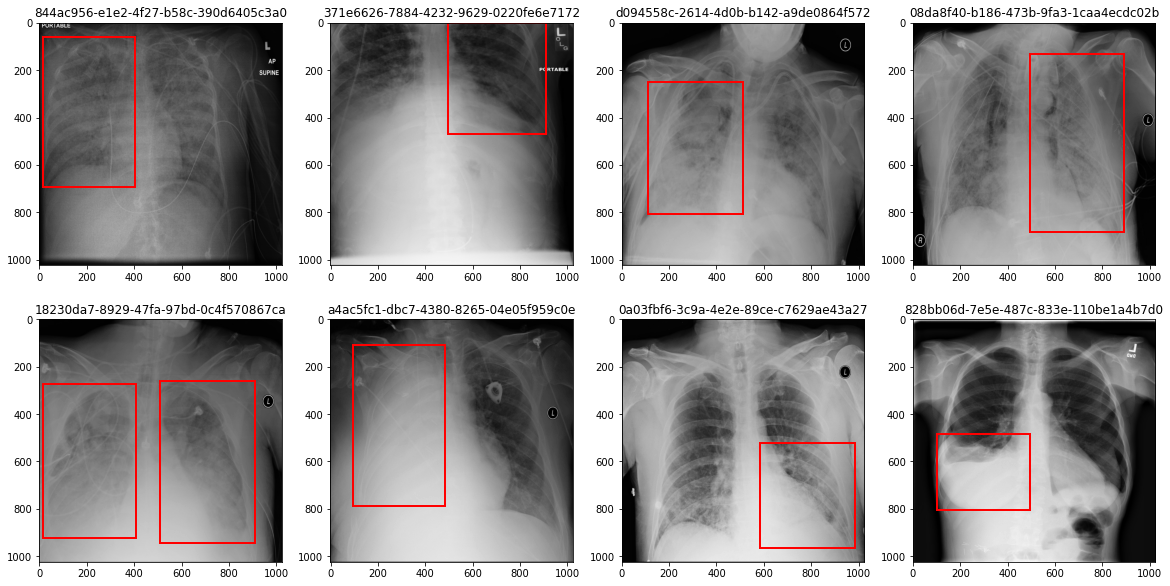

In [73]:
#Diplay the outlier image cases with bounding boxes
df = train_width_outliers.copy().reset_index(drop=True)

#Get some 6 random numbers and display those images
img_num = [np.random.randint(0, df.shape[0]) for i in range(8)]
display_image_and_bounding_boxes(df, img_num, img_path, fig_height = 20, fig_width = 10)

# EDA using AutoViz

In [ ]:
!pip install autoviz

Imported AutoViz_Class version: 0.0.81. Call using:
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
Note: verbose=0 or 1 generates charts and displays them in your local Jupyter notebook.
      verbose=2 saves plots in your local machine under AutoViz_Plots directory and does not display charts.
Shape of your Data Set: (30227, 6)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    Number of Numeric Columns =  4
    Number of Integer-Categorical Columns =  0
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  1
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  1


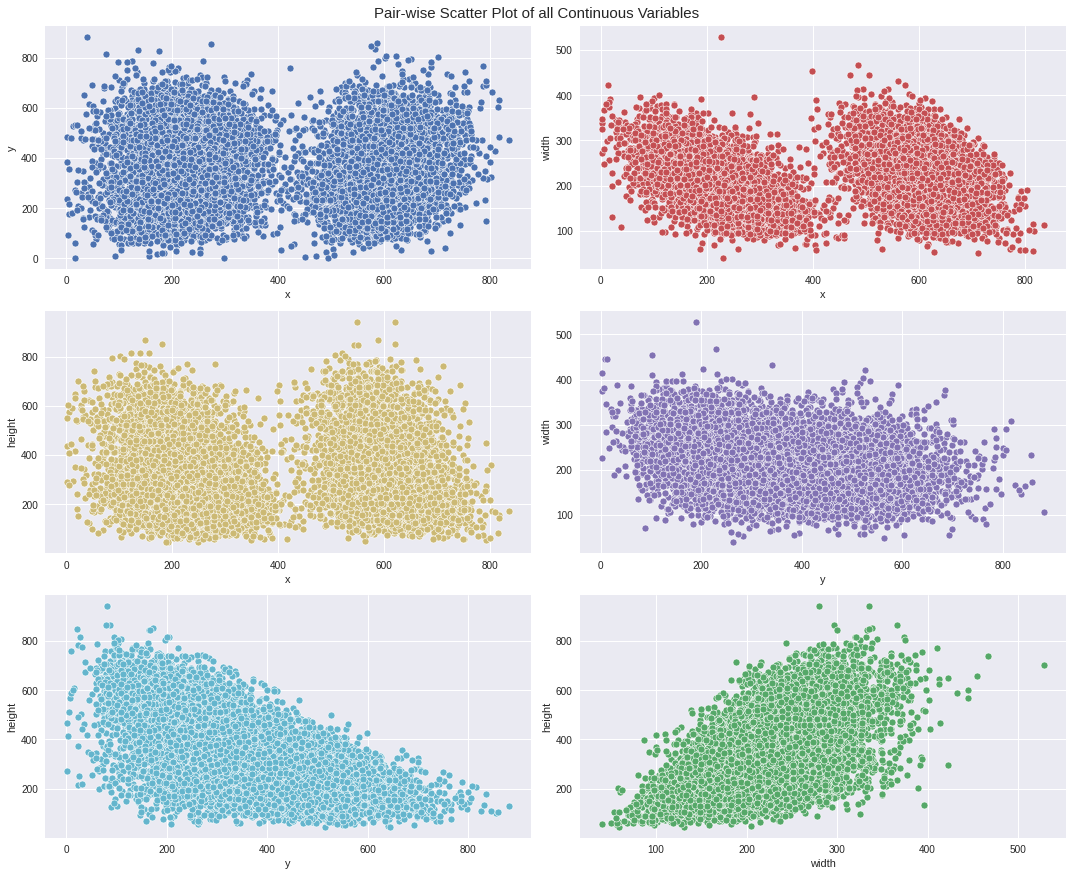

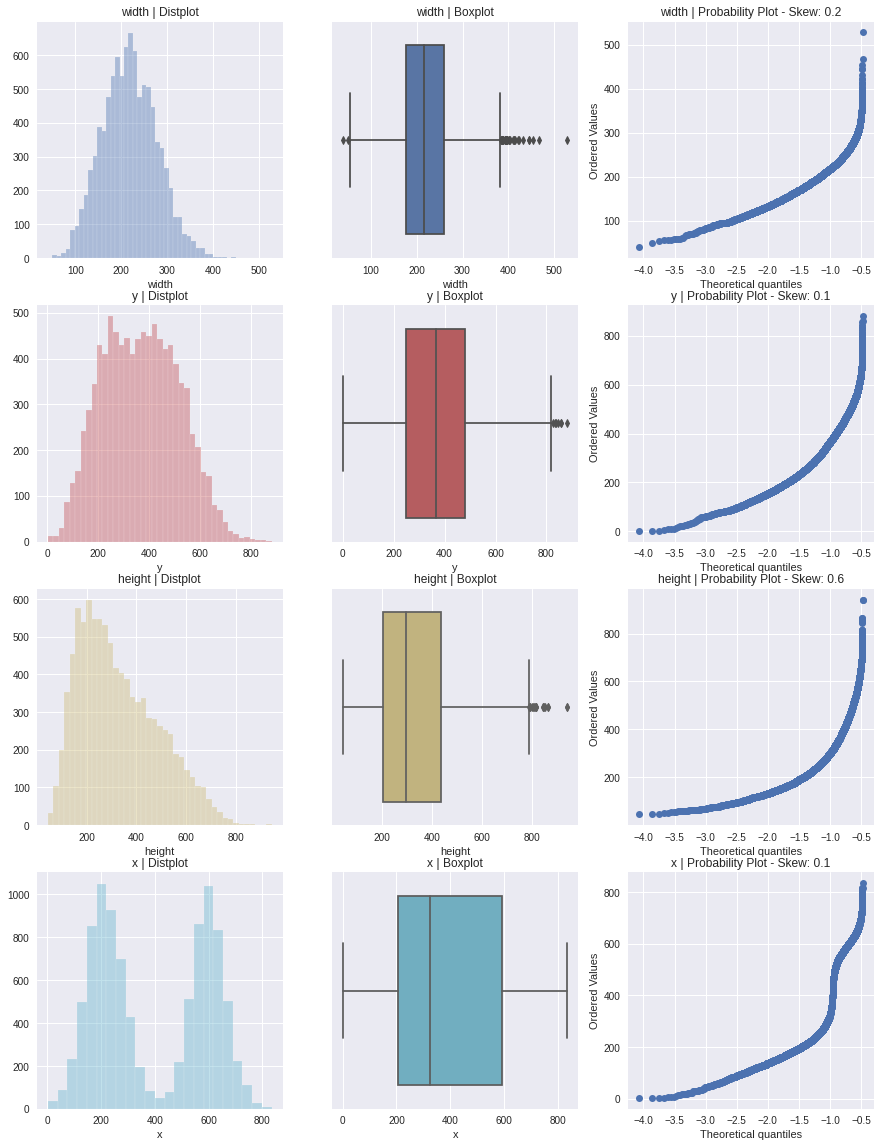

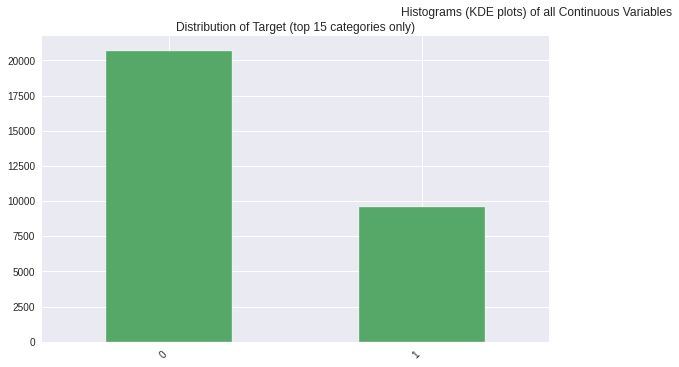

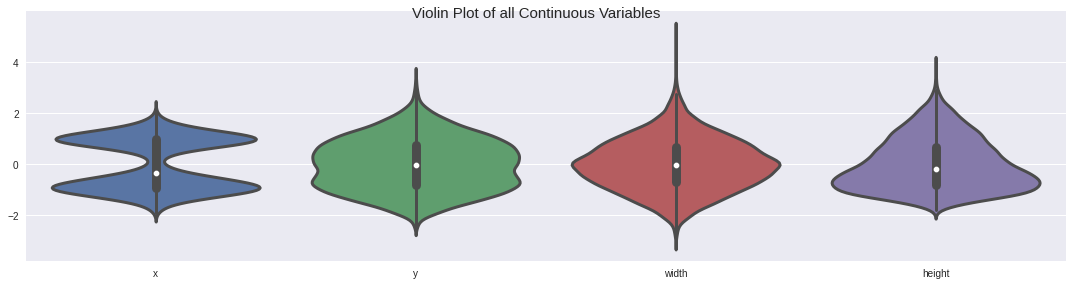

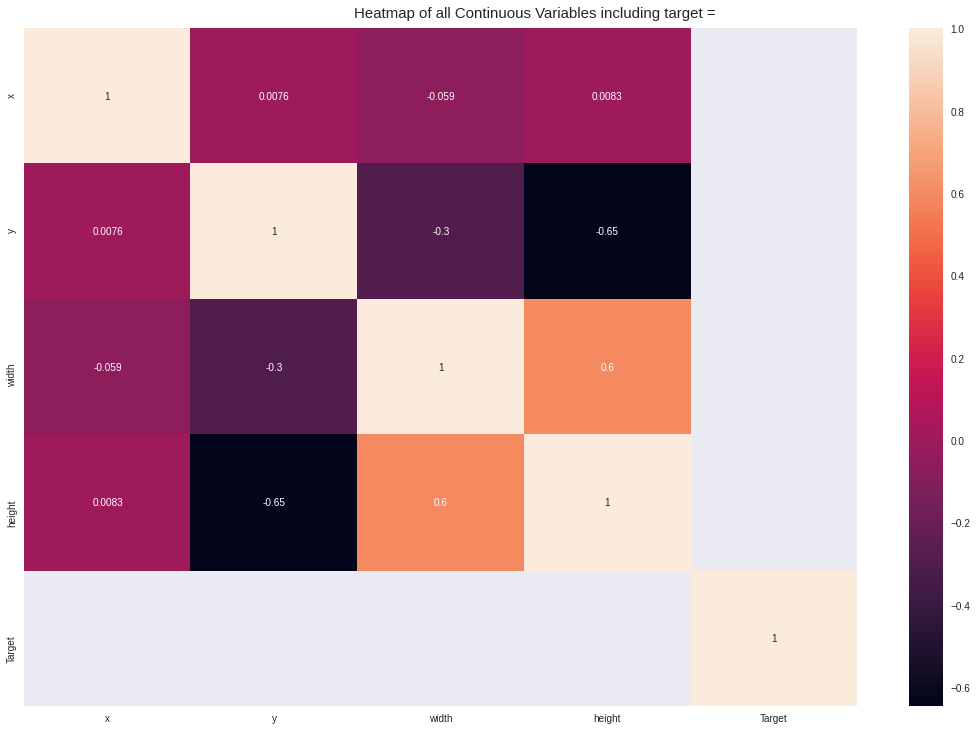

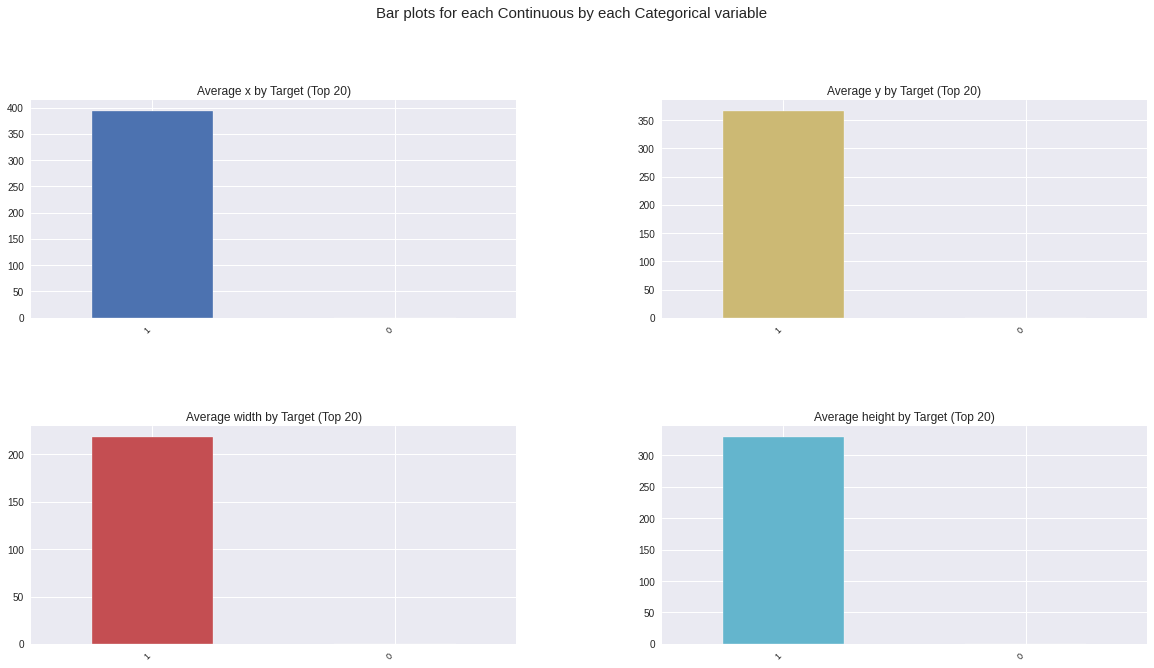

Time to run AutoViz (in seconds) = 7.441

 ###################### VISUALIZATION Completed ########################


,x,y,width,height,Target
0,NaN,NaN,NaN,NaN,0
1,NaN,NaN,NaN,NaN,0
2,NaN,NaN,NaN,NaN,0
3,NaN,NaN,NaN,NaN,0
4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...
30222,185.0,298.0,228.0,379.0,1
30223,NaN,NaN,NaN,NaN,0
30224,NaN,NaN,NaN,NaN,0
30225,570.0,393.0,261.0,345.0,1


In [ ]:
from autoviz.AutoViz_Class import AutoViz_Class

AV = AutoViz_Class()

AV.AutoViz('stage_2_train_labels.csv')

# EDA using D-Tale

In [ ]:
!pip install dtale

     |████████████████████████████████| 14.4MB 342kB/s 
     |████████████████████████████████| 194kB 40.1MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 645kB 30.0MB/s 
     |████████████████████████████████| 13.2MB 24.6MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
     |████████████████████████████████| 79.9MB 49kB/s 
     |████████████████████████████████| 1.8MB 29.2MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
     |████████████████████████████████| 358kB 43.1MB/s 
     |████████████████████████████████| 1.0MB 33.5MB/s 
     |████████████████████████████████| 3.5MB 25.3MB/s 
     |████████████████████████████████| 92kB 9.6MB/s 
     |████████████████████████████████| 1.8MB 26.5MB/s 
  Created wheel for dash-daq: filename=dash_daq-0.5.0-cp37-none-any.whl size=669704 sha256=0f66bf7fb2fc7d8f69c580f2bf108c22cc9dfc46fe83fb7a7e36cf0ef2a124b5
  Stored in di

In [ ]:
import dtale
import dtale.app as dtale_app

dtale_app.USE_COLAB = True

dtale.show(train_labels_df)

https://4owdu31hm1k-496ff2e9c6d22116-40000-colab.googleusercontent.com/dtale/main/1